In [2]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from HistogramLib.plot_manager import PlotManager
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
from hists.store import HistogramId

In [3]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v33'
histStore = HistogramStore(hist_folder, HistogramId)

In [4]:
h = histStore.get(HistogramId("RechitsMeanTotalEnergyPerEvent", "cmssw", "data")).getHistogram(HistogramKind.PROFILE)
h

Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy_custom', label='Beam energy (GeV)'), storage=Mean()) # Sum: Mean(count=281873, value=99.203, variance=4226.9)

In [5]:
def normalizeByBeamEnergy(h:hist.Hist) -> hist.Hist:
    new_h:hist.Hist = h.copy()
    new_view = new_h.view(flow=False)
    for i in range(new_h.axes[0].size):
        new_view.value[i] /= synchrotronBeamEnergiesMap[new_h.axes[0].bin(i)]
        new_view._sum_of_deltas_squared[i] /= (synchrotronBeamEnergiesMap[new_h.axes[0].bin(i)] ** 2)
    return new_h

def normalizeToAnotherHistogram(h:hist.Hist, ref:hist.Hist):
    new_h:hist.Hist = h.copy()
    new_view = new_h.view(flow=False)
    for i in range(new_h.axes[0].size):
        new_view.value[i] /= ref.view(flow=False).value[i]
        new_view._sum_of_deltas_squared[i] /= ref.view(flow=False).value[i]
    return new_h

In [6]:
def getHistograms(datatype):
    hists = [(histStore.get(HistogramId(histName, "cmssw", datatype))
        .getHistogram(HistogramKind.PROFILE))
     for histName in ["RechitsMeanTotalEnergyPerEvent", "MeanEnergyClustered2DPerEvent"]]
    
    hists.append(
        histStore.get(HistogramId("Clus3DMeanClusteredEnergy", "cmssw", datatype))
        .getHistogram(HistogramKind.PROFILE)
        [{"mainOrAllTracksters":hist.loc("mainTrackster")}]
        .project("beamEnergy_custom") # project on clus3D_size
    )
    labels = ["Rechits", "CLUE", "CLUE3D"]
    return hists, labels

def normalizeHistsToRechits(hists:list[hist.Hist], labels):
    rechits = hists[0]
    for i in range(1, len(hists)):
        hists[i] = normalizeToAnotherHistogram(hists[i], rechits)
    return hists[1:], labels[1:]


In [7]:
getHistograms("data")

([Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy_custom', label='Beam energy (GeV)'), storage=Mean()) # Sum: Mean(count=281873, value=99.203, variance=4226.9),
  Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy_custom', label='Beam energy (GeV)'), storage=Mean()) # Sum: Mean(count=281794, value=97.3855, variance=4194.02),
  Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy_custom', label='Beam energy (GeV)'), storage=Mean()) # Sum: Mean(count=281334, value=95.2936, variance=4089.78)],
 ['Rechits', 'CLUE', 'CLUE3D'])

In [49]:
def makePlots(datatype:str, norm:str, ax:plt.Axes=None, labels=None, lumi=True, plot_kwargs:dict[str, str]=dict(fmt='o-'), individual_plot_kwargs:list[dict]=None):
    """ norm can be "beamEnergy" or "rechits" """
    if ax is None:
        fig, ax = plt.subplots()
    plot_kwargs = plot_kwargs.copy()
    hists, labels_hist = getHistograms(datatype)
    
    if norm == "beamEnergy":
        hists = [normalizeByBeamEnergy(h) for h in hists]
    elif norm=="rechits":
        hists, labels_hist = normalizeHistsToRechits(hists, labels_hist)
    else:
        assert(False)
    
    if labels is None:
        labels = labels_hist

    #hep.histplot(hists, label=labels)
    fmt = plot_kwargs.pop("fmt")
    if individual_plot_kwargs is None:
        individual_plot_kwargs = [dict() for _ in labels]
    for h, label, individual_plot_kwargs_cur in zip(hists, labels, individual_plot_kwargs):
        plt.plot([h.axes[0].bin(i) for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,
             **(plot_kwargs | individual_plot_kwargs_cur))

    ax.set_xticks([h.axes[0].bin(i) for i in range(h.axes[0].size)])
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.set_xlabel("Nominal beam energy (GeV)")
    if norm == "beamEnergy":
        ax.set_ylabel("Mean reconstructed energy\nnormalized by beam energy (incl. synchroton losses)")
    elif norm=="rechits":
        ax.set_ylabel("Mean reconstructed energy\nnormalized by the mean energy at rechit level")
    
    ax.legend()
    if lumi:
        if "data" == datatype:
            hep.cms.text("Preliminary", ax=ax)
        else:
            hep.cms.text("Simulation Preliminary", ax=ax)
        hep.cms.lumitext("$e^+$ test beam", ax=ax)

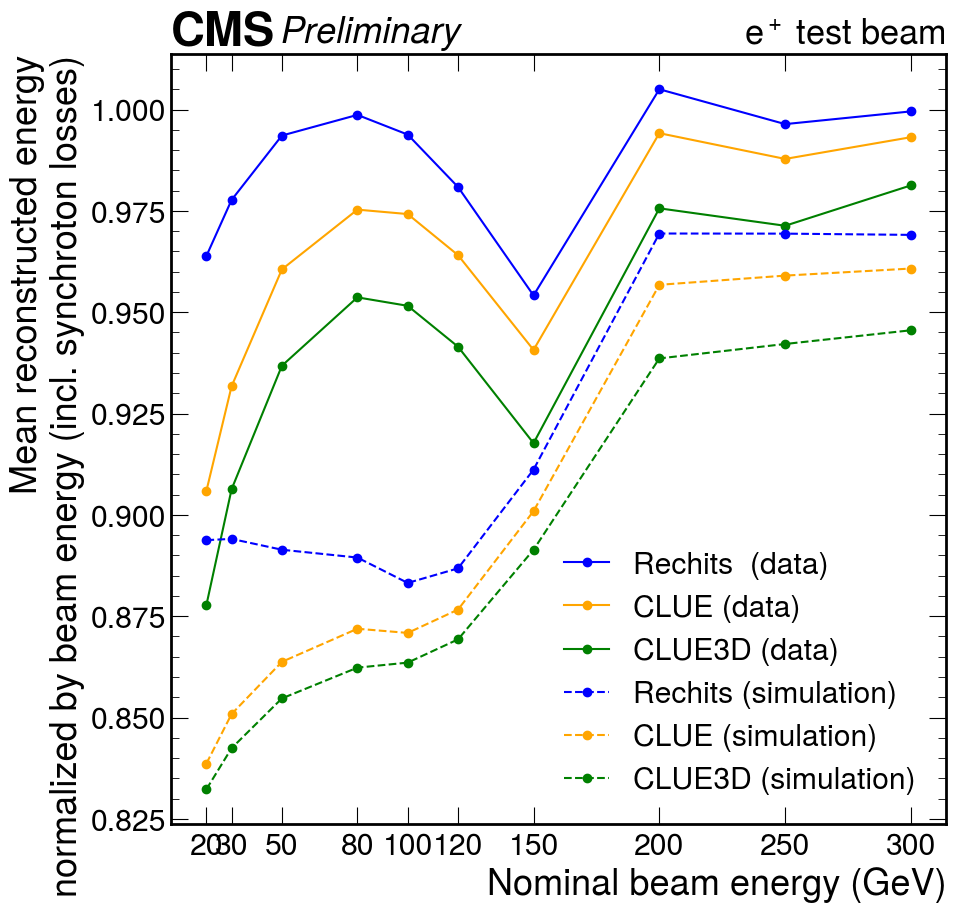

In [53]:
fig, ax = plt.subplots()
makePlots("data", "beamEnergy", ax=ax, labels=["Rechits  (data)", "CLUE (data)", "CLUE3D (data)"],
    individual_plot_kwargs=[dict(color="blue"), dict(color="orange"), dict(color="green")])
makePlots("sim_proton_v46_patchMIP", "beamEnergy", ax=ax, labels=["Rechits (simulation)", "CLUE (simulation)", "CLUE3D (simulation)"], lumi=False,
    plot_kwargs=dict(fmt="o--"), individual_plot_kwargs=[dict(color="blue"), dict(color="orange"), dict(color="green")])

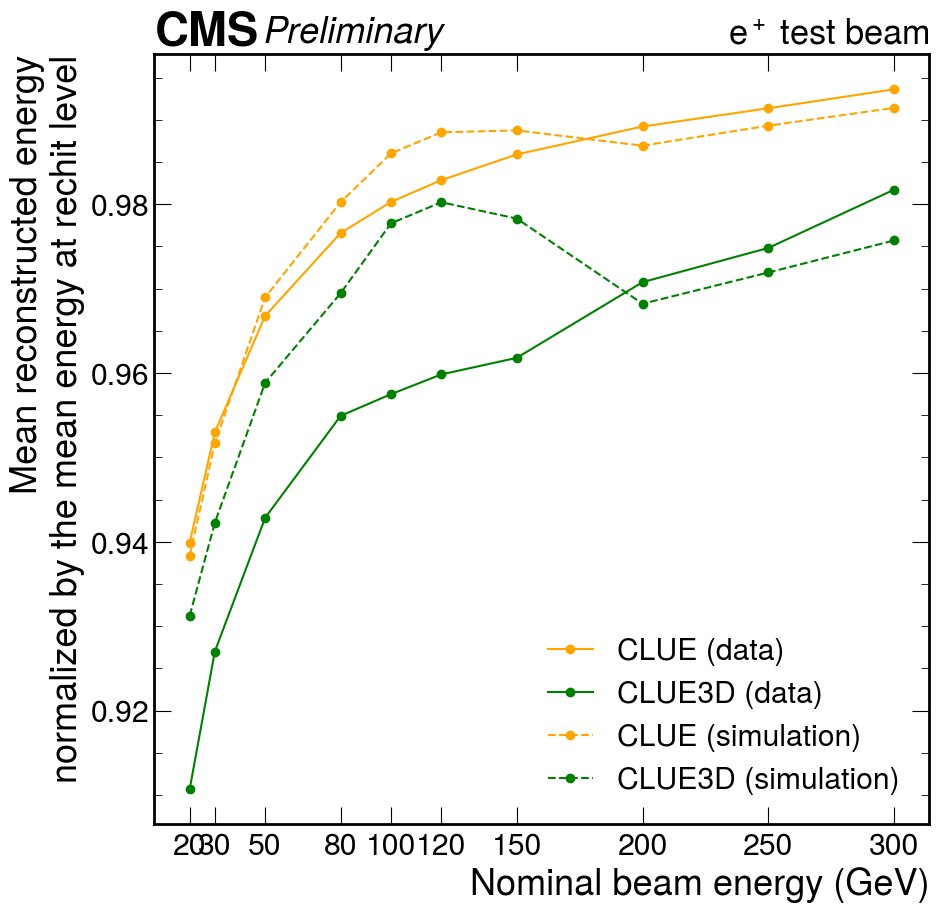

In [54]:
fig, ax = plt.subplots()
makePlots("data", "rechits", ax=ax, labels=["CLUE (data)", "CLUE3D (data)"], 
    individual_plot_kwargs=[dict(color="orange"), dict(color="green")])
makePlots("sim_proton_v46_patchMIP", "rechits", ax=ax, labels=["CLUE (simulation)", "CLUE3D (simulation)"], lumi=False,
    plot_kwargs=dict(fmt="o--"), individual_plot_kwargs=[dict(color="orange"), dict(color="green")])

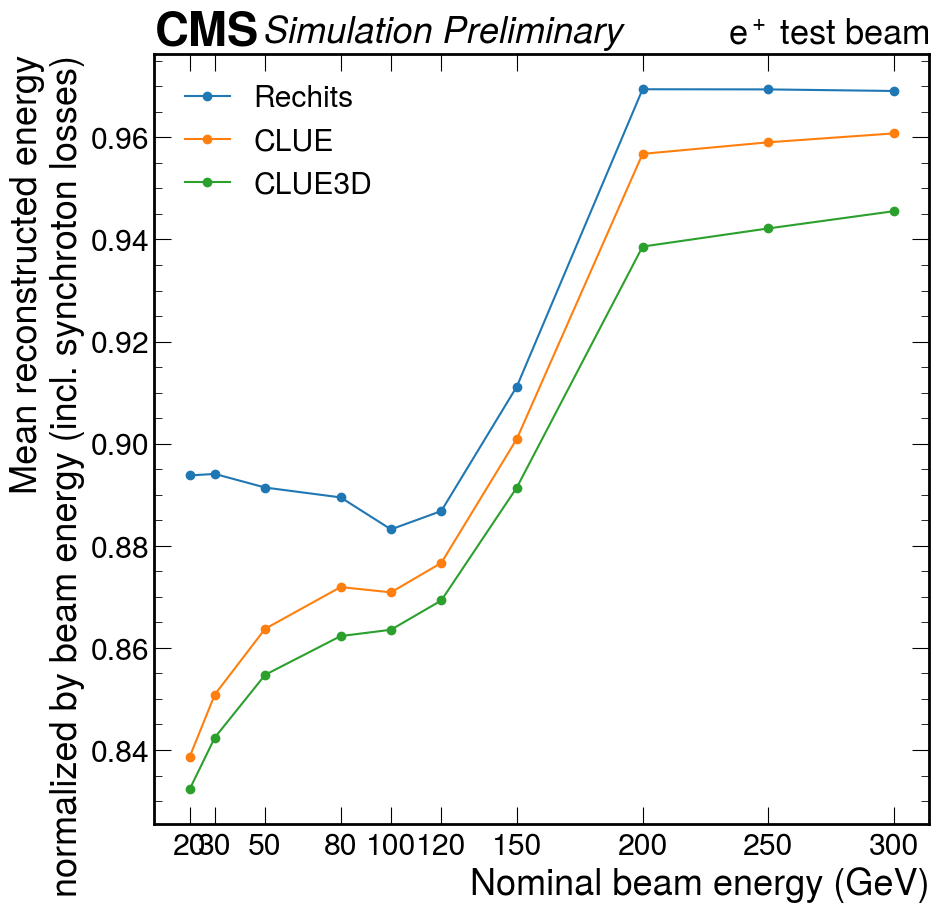

In [ ]:
makePlots("sim_proton_v46_patchMIP")